# Project 3

## Team Members

*Simon Ustoyev

*Elina Azrilyan

*Jack Russo

*Anil Akyildirim

## Introduction

In this assignment, we will be creating a name gender classifier by using the names corpus , splitting into three subsets, starting with the name classifier and further create new feauture set and then evaluate the performance with the test set.

[Assignment Video](https://screencast-o-matic.com/watch/cYihI35xbr)

In [1]:
import nltk
from nltk.corpus import names
import pandas as pd
import random
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

## Data Collection

Male and Female names have different characteristics. Names ending in a, e and i are likely to be female, while names ending k,o,r,s and t are likely to be male. First we are going to load the names corpus.

In [2]:
# Load the names corpus, use random to shuffle the names
labeled_names = ([(name, 'male') for name in names.words('male.txt')] +
                 [(name, 'female') for name in names.words('female.txt')])
random.shuffle(labeled_names)

In [3]:
labeled_names[0:5]

[('Mortimer', 'male'),
 ('Rik', 'male'),
 ('Hallie', 'female'),
 ('Verla', 'female'),
 ('Torr', 'male')]

## Feature Definition and Creation

First thing we do is to find what features of the input are relevant and how we can encode these features. Based on Chapter 6 of the book, the first feature we will create is the final letter of a given name. 

In [4]:
# gender_features -reference http://www.nltk.org/book/ch06.html
def gender_features(name):
  return {'last_letter': name[-1]}

Second feature we will use the common approach "kitchen sink" where we include all the features that we think of for gender classification as example 2 of the book. In this example, feature is defined as last letter of the name as per the first example, first letter , number of times each letter appears in the name and if the letter was present in the name at all.

In [5]:
# gender_features_overfit - reference http://www.nltk.org/book/ch06.html 
def gender_features_overfit(name):
    features = {}
    features["first_letter"] = name[0].lower()
    features["last_letter"] = name[-1].lower()
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count({})".format(letter)] = name.lower().count(letter)
        features["has({})".format(letter)] = (letter in name.lower())
    return features

The last example that is provided in the book is based on looking at the errors of the second example where it is clear that some suffixes that are more than one letter can be indicative of name genders. We can add this as a feature example 3. This feature is looking for the first and last two letters in the name.

In [6]:
# gender_features_suffix -reference http://www.nltk.org/book/ch06.html
def gender_features_suffix(word):
  return {'suffix1': word[-1:], 'suffix2': word[-2:]}

After looking at all these three feature definitions, we can create our own by enhancing the first two examples. We will include the first letter, last letter as per example 2, suffix as example 3 with the condition of the length of the name and look for consonant blends in a name. (Reference: https://arxiv.org/pdf/1606.05467.pdf ) . The list of consonant blends can be found here: (https://www.enchantedlearning.com/consonantblends/#:~:text=Consonant%20blends%20

In [7]:
def gender_features_add_on(name):
    features = {}
    temp_name = name
    consonant_blends = ["bl", 
                         "br", 
                         "ch", 
                         "cl", 
                         "cr", 
                         "dr", 
                         "fl", 
                         "fr", 
                         "gl", 
                         "gr", 
                         "pl", 
                         "pr", 
                         "sc", 
                         "sh", 
                         "sk", 
                         "sl", 
                         "sm", 
                         "sn", 
                         "sp", 
                         "st", 
                         "sw", 
                         "th", 
                         "tr", 
                         "tw", 
                         "wh", 
                         "wr", 
                         "sch", 
                         "scr", 
                         "shr", 
                         "sph", 
                         "spl", 
                         "spr", 
                         "squ", 
                         "str", 
                         "thr"]
    features["firstletter"] = name[0].lower() 
    features["lastletter"] = name[-1].lower() 
    features["suffix1"] = name[:3].lower() if len(name) > 4 else name[:2].lower() 
    features["suffix2"] = name[-3:].lower() if len(name) > 4 else name[-2:].lower()
    clusters = []
    for cluster in consonant_blends[::-1]:
        if cluster in temp_name:
            temp_name = temp_name.replace(cluster, "")
            clusters.append(cluster)
    features["consonant_blends_1"] = clusters[0] if len(clusters) > 0 else None
    features["consonant_blends_2"] = clusters[1] if len(clusters) > 1 else None
    features["consonant_blends_3"] = clusters[2] if len(clusters) > 2 else None
    return features

After creating our feature by combining the example feature sets and adding additional feature. We can add additional possible features. Below are some ideas;

1- Define the number of syllables: Female names have more syllables than male names.

2- Number of consonants: Male names have more consonants than female names. (We have used consonants in our set

3- Number of vowels: Female name contains more vowels than male name.

4- Ending Character: Female names end more often with a vowel than male names.

Out of these four ideas, let's try two of them. Number 1 and 4.

In [8]:
#Combined with last is vowel, last letter, last three, two, letter.
def vowel_features(name):
    return({'last_is_vowel': (name[-1] in 'aeiouy'),
            'last_letter': name[-1],
            'last_three': name[-3:],
            'last_two': name[-2:]})

In [9]:
# Number of Syllables: Female names tend to have more syllables than their male counterparts.
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return ({'syllables count' : count})

We have three main feature functions that we defined. Let's create a function that takes the function name as an aurgument and return the feature set.

In [10]:
# choose features
def choose_features(metric):
  if metric == "gender_features_add_on":
    return([(gender_features_add_on(n), gender) for (n, gender) in labeled_names])
  if metric == "vowel_features":
    return([(vowel_features(n), gender) for (n, gender) in labeled_names])
  if metric== 'syllable_count':
    return([(syllable_count(n), gender) for (n, gender) in labeled_names])
  else:
    print("No Metric Found")

## Naive Bayes Classification and Accuracy

We are going to use Naive Bayes as a Classifier. We are going to look at the 3 feature functions we created and create a model for each and then compare the accuracy of the gender classifiers.

In [11]:
# gender_features_add_on
featuresets = choose_features(metric = "gender_features_add_on")
train_set, dev_test_set, test_set = featuresets[1000:], featuresets[500:1000], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
gender_features_add_on_accuracy_1 = nltk.classify.accuracy(classifier, dev_test_set)
gender_features_add_on_features_1 = classifier.show_most_informative_features(5)
# vowel_features
featuresets = choose_features(metric = "vowel_features")
train_set, dev_test_set, test_set = featuresets[1000:], featuresets[500:1000], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
vowel_features_accuracy_1 = nltk.classify.accuracy(classifier, dev_test_set)
vowel_features_informative_1 = classifier.show_most_informative_features(5)
# syllable_count
featuresets = choose_features(metric = "syllable_count")
train_set, dev_test_set, test_set = featuresets[1000:], featuresets[500:1000], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
syllable_count_accuracy_1 = nltk.classify.accuracy(classifier, dev_test_set)
syllable_count_informative_1 = classifier.show_most_informative_features(5)

Most Informative Features
              lastletter = 'k'              male : female =     41.2 : 1.0
              lastletter = 'a'            female : male   =     34.4 : 1.0
                 suffix2 = 'ard'            male : female =     27.3 : 1.0
                 suffix2 = 'ita'          female : male   =     24.0 : 1.0
                 suffix2 = 'tta'          female : male   =     22.7 : 1.0
Most Informative Features
                last_two = 'na'           female : male   =     93.9 : 1.0
                last_two = 'la'           female : male   =     66.8 : 1.0
             last_letter = 'k'              male : female =     41.2 : 1.0
                last_two = 'ia'           female : male   =     37.4 : 1.0
             last_letter = 'a'            female : male   =     34.4 : 1.0
Most Informative Features
         syllables count = 4              female : male   =      3.6 : 1.0
         syllables count = 3              female : male   =      2.0 : 1.0
         syllables cou

In [12]:
# gender_features_add_on
featuresets = choose_features(metric = "gender_features_add_on")
train_set, dev_test_set, test_set = featuresets[1000:], featuresets[500:1000], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
gender_features_add_on_accuracy_2 = nltk.classify.accuracy(classifier, test_set)
gender_features_add_on_features_2 = classifier.show_most_informative_features(5)
# vowel_features
featuresets = choose_features(metric = "vowel_features")
train_set, dev_test_set, test_set = featuresets[1000:], featuresets[500:1000], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
vowel_features_accuracy_2 = nltk.classify.accuracy(classifier, test_set)
vowel_features_informative_2 = classifier.show_most_informative_features(5)
# syllable_count
featuresets = choose_features(metric = "syllable_count")
train_set, dev_test_set, test_set = featuresets[1000:], featuresets[500:1000], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
syllable_count_accuracy_2 = nltk.classify.accuracy(classifier, test_set)
syllable_count_informative_2 = classifier.show_most_informative_features(5)

Most Informative Features
              lastletter = 'k'              male : female =     41.2 : 1.0
              lastletter = 'a'            female : male   =     34.4 : 1.0
                 suffix2 = 'ard'            male : female =     27.3 : 1.0
                 suffix2 = 'ita'          female : male   =     24.0 : 1.0
                 suffix2 = 'tta'          female : male   =     22.7 : 1.0
Most Informative Features
                last_two = 'na'           female : male   =     93.9 : 1.0
                last_two = 'la'           female : male   =     66.8 : 1.0
             last_letter = 'k'              male : female =     41.2 : 1.0
                last_two = 'ia'           female : male   =     37.4 : 1.0
             last_letter = 'a'            female : male   =     34.4 : 1.0
Most Informative Features
         syllables count = 4              female : male   =      3.6 : 1.0
         syllables count = 3              female : male   =      2.0 : 1.0
         syllables cou

In [13]:
gender_features_add_on_accuracy_1

0.844

In [14]:
vowel_features_accuracy_1

0.798

In [15]:
syllable_count_accuracy_1

0.62

In [16]:
gender_features_add_on_accuracy_2

0.82

In [17]:
vowel_features_accuracy_2

0.782

In [18]:
syllable_count_accuracy_2

0.624

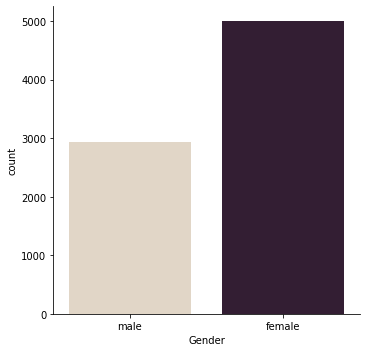

In [19]:
df = pd.DataFrame(labeled_names[0:])
df.columns=['Name', 'Gender']
df.head()
sns.catplot(x="Gender", kind="count", palette="ch:.25", data=df)

## Conclusion

In this project, we have created a gender classification models using Naive Bayes with using different feature sets we have created. We have taken the 3 example feature definitions from the book and created one enhanced version of feature set and two additional features to be used in classification. We have created the classification models and tested both with dev_test_set and test_set. gender_features_add_on feature we used for naive bayes classification with dev_test_set has the highest accuracy (81%) which is consitent with the classification method and feature set when used in test set we see the accuracy of 83%. Comparing all there feature set, gender_features_add_on has the highest accuracy, followed by vowel_feature and syllable_count feature.